## Contents

- [Setup](#setup)
- [Problem statement](#problem-statement)
- [Model setup](#model-setup)
  - [Initial cross-validation](#initial-cross-validation)
  - [Feature selection](#feature-selection)
- [Model creation and testing](#model-creation-and-testing)
  - [Comparing to baseline](#comparing-to-baseline)
- [Practical use](#practical-use)
- [Bonus - Ridge Regression](#bonus---ridge-regression)
    

## Setup

In [1]:
# load libraries

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# model requirements
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.dummy import DummyRegressor

# some models were throwing warnings, suppress them
import warnings
warnings.filterwarnings(action='ignore')

# plot options
%matplotlib inline
# set overall plot style
sns.set_theme(style='white', palette='muted', font='sans-serif', font_scale=2.5)
plt.rcParams['figure.facecolor'] = '#FFF8E7'
plt.rcParams['axes.facecolor'] = '#FFFEFA'
# specify a custom font and properties for axes
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Inter'
plt.rcParams['axes.labelcolor'] = '#991410'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 15
# increase figure size
plt.rcParams['figure.figsize'] = (25,12)

# read the cleaned data in
results = pd.read_csv('data/detailed_results.csv').drop(columns='Unnamed: 0')
dnfs = pd.read_csv('data/detailed_dnfs.csv').drop(columns='Unnamed: 0')

# set display to 2 decimal places in dataframes
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Problem statement

**Can you predict the finishing time of a given athlete profile for a given race?**

## Model setup

This model aims to estimate a runner's finishing time in seconds for a race. Possible features for the model are the runner's age, gender, and nationality along with race distance, elevation, no. of aid stations, no. of participants, and race location (city).

In [2]:
# select just the columns we need
data = results[['time_in_seconds', 'age', 'gender', 'nationality',
                'city', 'distance', 'elevation_gain', 'elevation_loss',
                'aid_stations', 'participants']]

As there are 3 categorical variables in our dataset (gender, nationality, city), we need to convert them into dummy variables using one-hot encoding. This expands the categories to become features themselves, with a `0` encoding the athlete does not belong to that category, and a `1` encoding membership of a category.

In [3]:
# dummify categorical variables: runner gender, runner nationality, race city
# by default get_dummies only encodes non-numeric features of a dataframe
data_dm = pd.get_dummies(data, drop_first=True)

# tidy up some column names
data_dm.rename(columns={"time_in_seconds": "time",
                        "age": "runner_age",
                        "gender_W": "runner_gender"},
               inplace=True)
data_dm.rename(columns=lambda x: x.replace("nationality", "runner_nationality"), inplace=True)

data_dm.head(5)

,time,runner_age,distance,elevation_gain,elevation_loss,aid_stations,participants,runner_gender,runner_nationality_AND,runner_nationality_ARG,...,city_Yibin,city_Yichang,city_Ystad,city_Zagreb,city_Zalesie,city_Zhaotong,city_Äkäslompolo,city_Åsa,city_Örebro,city_İstanbul
0,95725.00,30,166.90,4520,-4520,10,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,97229.00,43,166.90,4520,-4520,10,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,103747.00,38,166.90,4520,-4520,10,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,111217.00,55,166.90,4520,-4520,10,150,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,117981.00,48,166.90,4520,-4520,10,150,1,0,0,...,0,0,0,0,0,0,0,0,0,0


This encoded data can then be split into training and testing sets, with the testing set put aside until a model is trained for final testing. The sets `X_train` and `y_train` become the data on which the model will be trained.

In [4]:
# training / test split

X = data_dm.drop(columns='time')
y = data_dm.time

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

### Initial cross-validation

While the testing data is put aside, the training data can itself be further split and shuffled to provide a validation score for how a model deals with new, 'unknown' data. This is done with KFold validation.

In [5]:
# instantiate model and K-fold cross validation object
lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=2022)

In [6]:
# perform cross validation
val_scores = cross_validate(lr, X_train, y_train, cv=kf, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

print(f"""
----- Cross Validation Results -----
Train RMSE: {np.sqrt(-val_scores['train_neg_mean_squared_error']).mean()}
Train RMSE as hours: {np.sqrt(-val_scores['train_neg_mean_squared_error']).mean()/3600}
Train R2: {val_scores['train_r2'].mean()}
Test RMSE: {np.sqrt(-val_scores['test_neg_mean_squared_error']).mean()}
Test RMSE as hours: {np.sqrt(-val_scores['test_neg_mean_squared_error']).mean()/3600}
Test R2: {val_scores['test_r2'].mean()}
-------------------------------------
""")


----- Cross Validation Results -----
Train RMSE: 18669.24176487618
Train RMSE as hours: 5.185900490243384
Train R2: 0.7445142195526304
Test RMSE: 6292082509.582213
Test RMSE as hours: 1747800.6971061705
Test R2: -56745276872.53794
-------------------------------------



This cross validation shows that the model averages a solid training R2 of ~74% but a staggeringly bad testing R2 (which can be infinitely negative "because the model can be arbitrarily worse"). RMSEs for testing is also large, even when converted from seconds to a slightly more practically useful measure of hours.

This terrible 'real life' score from validation is most likely because the data is massively overfitted to the training data with all those variables. So what features are important to keep?

### Feature selection

As there are so many features in the data as a result of the dummy encoding, it may not be practical to investigate their impact on the model manually by inspecting coefficients. It would be a shame to potentially lose the information contained in the categorical variables, so I decided to investigate an automated way to see how many and which variables should be included in the model using a pipeline to apply a `SelectKBest` function to the data prior to model fitting.



In [7]:
# =======
# WARNING
# =======
# This cell takes a long time to run!

# create dictionaries to store results
scores = {}
rmses = {}

# loop through all the possible numbers of variables included in the model,
# fit each one using a pipeline with SelectKBest and a Linear Regression model,
# and store the results in the dictionaries
for n in range(1, 430):
	lr_selected = make_pipeline(SelectKBest(f_regression, k=n), LinearRegression())
	lr_selected.fit(X_train, y_train)
	score = lr_selected.score(X_test, y_test)
	scores[str(n)] = score
	rmse = np.sqrt(metrics.mean_squared_error(y_test, lr_selected.predict(X_test)))
	rmses[str(n)] = rmse

Once this code is run, what number of features is found to produce the best model results?

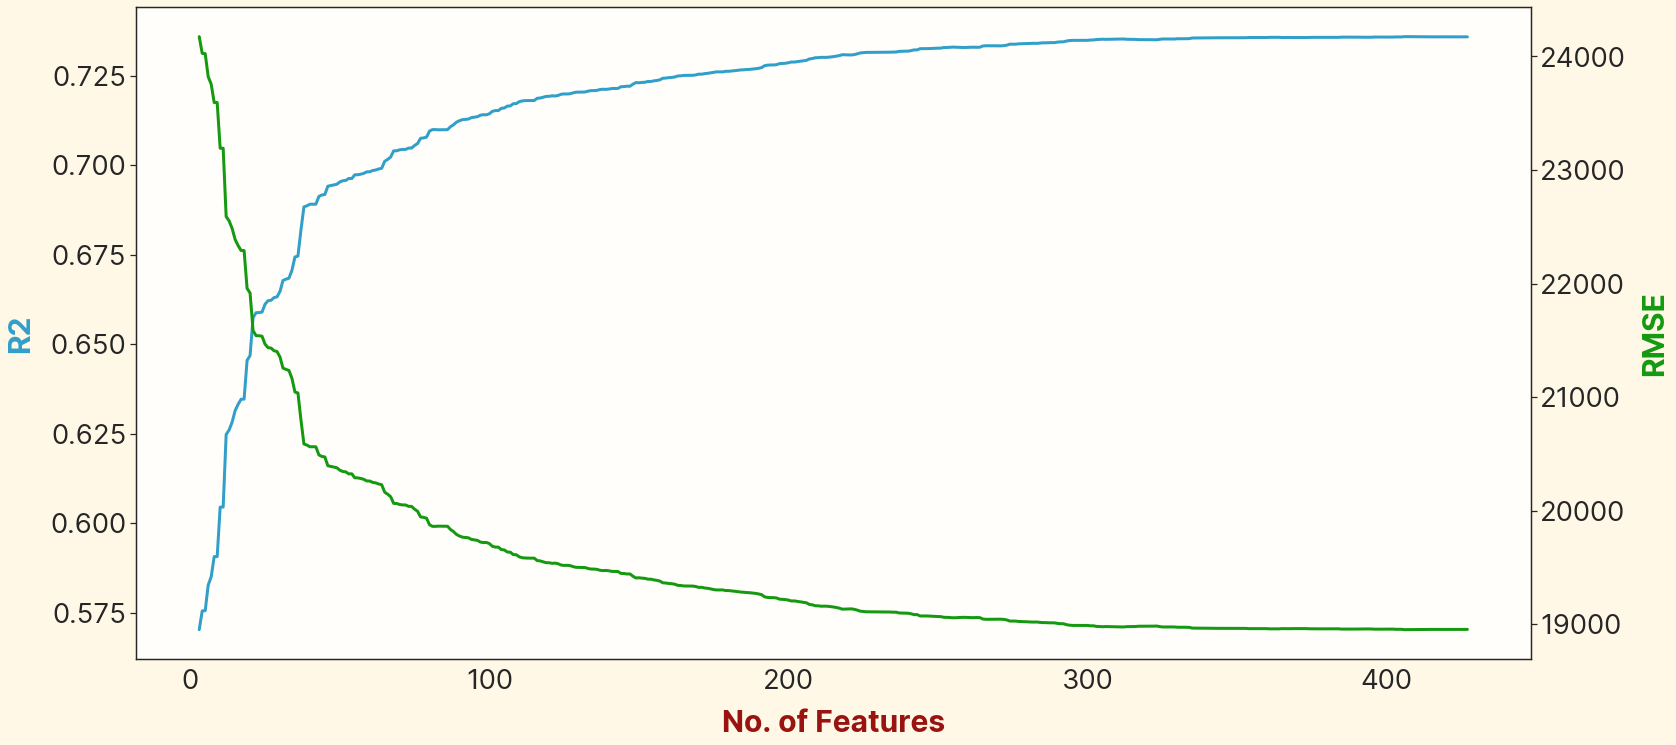

In [8]:
# for convenience, save the results in a dataframe
# and save to csv for use in presentation without re-running feature selection code
feature_scores = pd.DataFrame(data={"r2": scores.values(), "rmse": rmses.values()}, index=scores.keys())

feature_scores.to_csv('data/feature_scores.csv')

# this can also be used to extract the features with a positive score for plotting
r2_vals = feature_scores.r2[feature_scores.r2 > 0.5]
rmse_vals = feature_scores.rmse[feature_scores.r2 > 0.5]
x_vals = feature_scores[feature_scores.r2 > 0.5].index.astype(int)

# plot the results of the feature selection
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.lineplot(x_vals, r2_vals, ax=ax1, label='R2', color='#309FC9', linewidth=3, legend=False)
sns.lineplot(x_vals, rmse_vals, ax=ax2, label='RMSE', color='#149910', linewidth=3, legend=False)

ax1.set_xlabel('No. of Features')
ax1.set_ylabel('R2', color='#309FC9')
ax2.set_ylabel('RMSE', color='#149910')

plt.show()

In [9]:
# check the top 10 R2 value results
feature_scores.sort_values(by='r2', ascending=False).head(10)

,r2,rmse
406,0.74,18952.05
408,0.74,18952.35
407,0.74,18952.35
409,0.74,18952.44
410,0.74,18952.51
411,0.74,18952.70
419,0.74,18953.98
417,0.74,18954.06
418,0.74,18954.16
420,0.74,18954.30


In [10]:
# check the top ten RMSE value results
feature_scores.sort_values(by='rmse').head(10)

,r2,rmse
406,0.74,18952.05
408,0.74,18952.35
407,0.74,18952.35
409,0.74,18952.44
410,0.74,18952.51
411,0.74,18952.70
419,0.74,18953.98
417,0.74,18954.06
418,0.74,18954.16
420,0.74,18954.30


Checking the results of the `SelectKBest` testing, a model with 406 variables seems to produce the best results.

## Model creation and testing

Now that we know to use 406 variables, we can re-check our cross-validation results:

In [11]:
# re-check cross-validation for 406 features
lr_model = make_pipeline(SelectKBest(f_regression, k=406), LinearRegression())

# perform cross validation
new_val_scores = cross_validate(lr_model, X_train, y_train, cv=kf, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

print(f"""
----- Cross Validation Results -----
Train RMSE: {np.sqrt(-new_val_scores['train_neg_mean_squared_error']).mean()}
Train RMSE as hours: {np.sqrt(-new_val_scores['train_neg_mean_squared_error']).mean()/3600}
Train R2: {new_val_scores['train_r2'].mean()}
Test RMSE: {np.sqrt(-new_val_scores['test_neg_mean_squared_error']).mean()}
Test RMSE as hours: {np.sqrt(-new_val_scores['test_neg_mean_squared_error']).mean()/3600}
Test R2: {new_val_scores['test_r2'].mean()}
-------------------------------------
""")


----- Cross Validation Results -----
Train RMSE: 18671.68085122933
Train RMSE as hours: 5.186578014230369
Train R2: 0.7444475485541255
Test RMSE: 18780.716818056364
Test RMSE as hours: 5.216865782793435
Test R2: 0.7413891601348425
-------------------------------------



Now our test R2 and RMSE are a lot better, and nearly match the training results. So now the final model can be officially trained on the training data:

In [12]:
# fit training data to final model
lr_model.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=406,
                             score_func=<function f_regression at 0x7f833ae5d280>)),
                ('linearregression', LinearRegression())])

And finally, tested against the holdout testing data set:

In [13]:
print(f"""
----- Final Model Results -----
R2: {round(lr_model.score(X_test, y_test), 2)}
RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, lr_model.predict(X_test))), 2)}
RMSE in hrs: {round(np.sqrt(metrics.mean_squared_error(y_test, lr_model.predict(X_test))) / 3600, 2)}
-------------------------------
""")


----- Final Model Results -----
R2: 0.74
RMSE: 18952.05
RMSE in hrs: 5.26
-------------------------------



This now produces model metrics similar to those seen in cross-validation, with an R2 of **74%** and an RMSE of **18952.05** seconds, or around **5.26** hours.

### Comparing to baseline

~5 hours may be quite a wide margin for a race result - does our final model, at the very least, beat a baseline model that is just guessing with the mean?

In [14]:
# how does this model compare to a simple baseline?

lr_dummy = make_pipeline(SelectKBest(f_regression, k=406), DummyRegressor(strategy='mean'))
lr_dummy.fit(X_train, y_train)

print(f"""
----- Dummy Model Results -----
Dummy R2:{round(lr_dummy.score(X_test, y_test), 2)}
Dummy RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, lr_dummy.predict(X_test))), 2)}
Dummy RMSE in hrs: {round(np.sqrt(metrics.mean_squared_error(y_test, lr_dummy.predict(X_test))) / 3600, 2)}
-------------------------------
""")


----- Dummy Model Results -----
Dummy R2:-0.0
Dummy RMSE: 36876.06
Dummy RMSE in hrs: 10.24
-------------------------------



The model does improve upon a dummy baseline model, with a much stronger R2 and smaller RMSE.

## Practical use

With all the dummy variables in the model, it would be difficult to manually enter an encoded set of data to specify an athletes nationality or a race location. Instead, a helper function can be used to enter new data for predictions:

In [15]:
# function to enter new data and get predicted finishing time back in human readable format
def predict_new_runner(age, gender, nat, distance, elevation_gain, elevation_loss, aid_stations, participants, city):
	# create a dataframe with a single row and the same feature column names,
	# but populated only by zeroes
	base = pd.DataFrame(np.zeros((1, len(X_train.columns)), dtype=np.int64), columns=X_train.columns)

	# set the values of the dataframe columns to the input values
	base.runner_age = age
	base.runner_gender = gender
	base.distance = distance
	base.elevation_gain = elevation_gain
	base.elevation_loss = elevation_loss
	base.aid_stations = aid_stations
	base.participants = participants
	# check if the given nationality and city are already in the
	# feature cols and encode if so, otherwise skip
	nat_col = "runner_nationality_" + nat
	if (nat_col in base.columns):
		base[nat_col] = 1
	city_col = "city_" + city
	if (city_col in base.columns):
		base[city_col] = 1

	# feed the new data to the model
	s = float(lr_model.predict(base))

	# assign a label to the gender data for nicer printing
	if (gender == 0): 
		gender_label = 'male'
	else:
		gender_label = 'female'

	# workout total elevation change
	if ((elevation_gain - elevation_loss) > 0): 
		elevation_label = 'gain'
	else:
		elevation_label = 'loss'

	print(f"""
	----- Predicted Outcome -----
	For a {age} year old {gender_label} from {nat}, running a {distance} km race in {city}
	with an elevation {elevation_label} of {abs(elevation_gain - elevation_loss)} ft, {participants} other runners, and {aid_stations} aid stations.
	
	Predicted finishing time: {pd.to_timedelta(s, unit='s')}
	-----------------------------
	""")

This function can then be passed new data to form a prediction:

In [16]:
# enter new data for a prediction
predict_new_runner(20, 0, "GBR", 155, 1000, 400, 10, 100, "Zagreb")


	----- Predicted Outcome -----
	For a 20 year old male from GBR, running a 155 km race in Zagreb
	with an elevation gain of 600 ft, 100 other runners, and 10 aid stations.
	
	Predicted finishing time: 1 days 03:00:13.388959575
	-----------------------------
	


## Bonus - Ridge Regression

After going through all of the above, I also discovered that using Ridge Regression instead of ordinary Linear Regression seemed to solve the issue with testing R2 without the need to use `SelectKBest`:

In [17]:
from sklearn.linear_model import Ridge

# instantiate Ridge Regression object
rdg = Ridge()

# perform cross validation for Ridge Regression model
rdg_val_scores = cross_validate(rdg, X_train, y_train, cv=kf, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

print(f"""
----- Cross Validation Results -----
Train RMSE: {np.sqrt(-rdg_val_scores['train_neg_mean_squared_error']).mean()}
Train RMSE as hours: {np.sqrt(-rdg_val_scores['train_neg_mean_squared_error']).mean()/3600}
Train R2: {rdg_val_scores['train_r2'].mean()}
Test RMSE: {np.sqrt(-rdg_val_scores['test_neg_mean_squared_error']).mean()}
Test RMSE as hours: {np.sqrt(-rdg_val_scores['test_neg_mean_squared_error']).mean()/3600}
Test R2: {rdg_val_scores['test_r2'].mean()}
-------------------------------------
""")


----- Cross Validation Results -----
Train RMSE: 18678.84421521424
Train RMSE as hours: 5.1885678375595115
Train R2: 0.7442513730579005
Test RMSE: 18780.14212984383
Test RMSE as hours: 5.216706147178841
Test R2: 0.74140731798193
-------------------------------------



In [18]:
# fit Ridge Regression model
rdg.fit(X_train, y_train)
rdg.score(X_test, y_test)

0.7358820947052946

In [19]:
# function to enter new data and get predicted finishing time back
# from Ridge Regression	model in human readable format
def rdg_predict_new_runner(age, gender, nat, distance, elevation_gain, elevation_loss, aid_stations, participants, city):
	# create a dataframe with a single row and the same feature column names,
	# but populated only by zeroes
	base = pd.DataFrame(np.zeros((1, len(X_train.columns)), dtype=np.int64), columns=X_train.columns)

	# set the values of the dataframe columns to the input values
	base.runner_age = age
	base.runner_gender = gender
	base.distance = distance
	base.elevation_gain = elevation_gain
	base.elevation_loss = elevation_loss
	base.aid_stations = aid_stations
	base.participants = participants
	# check if the given nationality and city are already in the
	# feature cols and encode if so, otherwise skip
	nat_col = "runner_nationality_" + nat
	if (nat_col in base.columns):
		base[nat_col] = 1
	city_col = "city_" + city
	if (city_col in base.columns):
		base[city_col] = 1

	# feed the new data to the model
	s = float(rdg.predict(base))

	# assign a label to the gender data for nicer printing
	if (gender == 0): 
		gender_label = 'male'
	else:
		gender_label = 'female'

	# workout total elevation change
	if ((elevation_gain - elevation_loss) > 0): 
		elevation_label = 'gain'
	else:
		elevation_label = 'loss'

	print(f"""
	----- Predicted Outcome -----
	For a {age} year old {gender_label} from {nat}, running a {distance} km race in {city}
	with an elevation {elevation_label} of {abs(elevation_gain - elevation_loss)} ft, {participants} other runners, and {aid_stations} aid stations.
	
	Predicted finishing time: {pd.to_timedelta(s, unit='s')}
	-----------------------------
	""")

In [20]:
# enter new data for a prediction from Ridge model
rdg_predict_new_runner(20, 0, "GBR", 155, 1000, 400, 10, 100, "Zagreb")


	----- Predicted Outcome -----
	For a 20 year old male from GBR, running a 155 km race in Zagreb
	with an elevation gain of 600 ft, 100 other runners, and 10 aid stations.
	
	Predicted finishing time: 1 days 02:54:09.802431778
	-----------------------------
	


When using Ridge Regression, the predicted values for the same new data are not too far from the results of manual feature selection performed initially - 1 day 3 hrs vs. 1 day, 2 hrs and 54 mins.

---

**Project Navigation:**

[◂ EDA Brief](01-EDA-Brief.html) **|** [Presentation ▸](03-Presentation.html)